In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import os
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/stocksdata.csv')

Drive already mounted at /stocksdata.csv; to attempt to forcibly remount, call drive.mount("/stocksdata.csv", force_remount=True).


In [ ]:
import pandas as pd

# Load dataset
# Assuming the file is directly uploaded or in the root directory based on previous interaction
# Correcting the file path to access the file from the mounted Google Drive
df = pd.read_csv('/content/stocks data.csv')

# Rename and format the date column
df.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
# Use dayfirst=True to handle mm-dd-yyyy format and errors='coerce' for invalid dates
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df.set_index('Date', inplace=True)

# Check for null values
print(df.isnull().sum())

Stock_1    0
Stock_2    0
Stock_3    0
Stock_4    0
Stock_5    0
dtype: int64


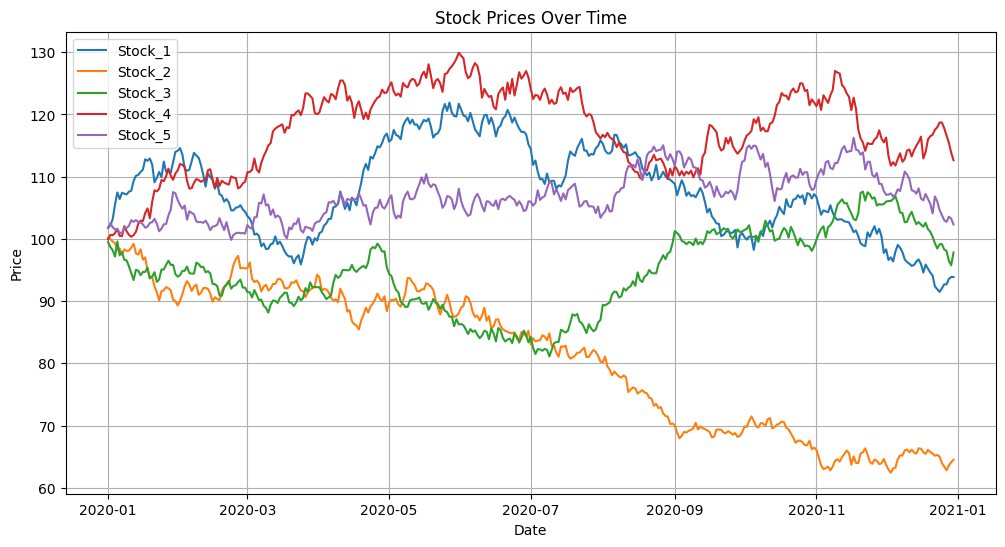

In [ ]:
plt.figure(figsize=(12, 6))
for stock in df.columns:
    plt.plot(df.index, df[stock], label=stock)
plt.legend()
plt.title("Stock Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()


In [ ]:
# Use past 5 days to predict the 6th day (sliding window)
from sklearn.preprocessing import MinMaxScaler

def create_features(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# We'll predict Stock_1 only
stock_data = df['Stock_1'].values.reshape(-1, 1)

# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(stock_data)

# Create features and labels
window_size = 5
X, y = create_features(scaled_data, window_size)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False)  # No shuffle for time series

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

# Reshape X_train and X_test to be 2D arrays for LinearRegression
# New shape will be (samples, window_size * number_of_features)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

lr.fit(X_train_reshaped, y_train)
y_pred_lr = lr.predict(X_test_reshaped)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Reshape X_train and X_test to be 2D arrays for RandomForestRegressor
# New shape will be (samples, window_size * number_of_features)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

rf.fit(X_train_reshaped, y_train.ravel())
y_pred_rf = rf.predict(X_test_reshaped)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np # Import numpy as it is used for np.sqrt

# Evaluate Linear Regression
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print("\nLinear Regression Model:")
print(f"  MSE: {mse_lr:.4f}")
print(f"  RMSE: {np.sqrt(mse_lr):.4f}")
print(f"  R² Score: {r2_lr:.4f}")

# Evaluate Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print("\nRandom Forest Model:")
print(f"  MSE: {mse_rf:.4f}")
print(f"  RMSE: {np.sqrt(mse_rf):.4f}")
print(f"  R² Score: {r2_rf:.4f}")


Linear Regression Model:
  MSE: 0.0009
  RMSE: 0.0305
  R² Score: 0.9605

Random Forest Model:
  MSE: 0.0056
  RMSE: 0.0746
  R² Score: 0.7641


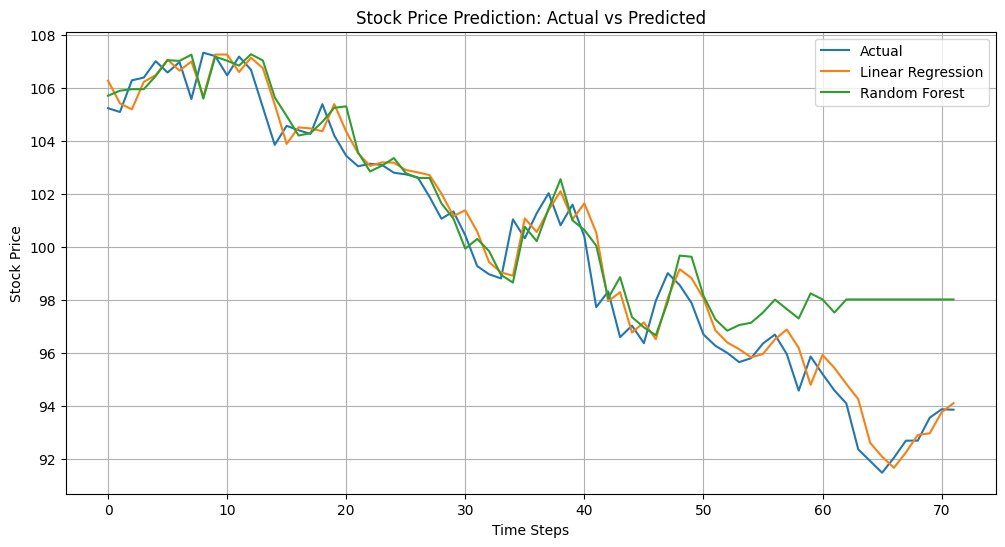

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), scaler.inverse_transform(y_test.reshape(-1, 1)), label="Actual")
plt.plot(range(len(y_test)), scaler.inverse_transform(y_pred_lr), label="Linear Regression")
plt.plot(range(len(y_test)), scaler.inverse_transform(y_pred_rf.reshape(-1, 1)), label="Random Forest")
plt.title("Stock Price Prediction: Actual vs Predicted")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Install these if not already installed
# pip install tensorflow

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [ ]:
def create_lstm_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i, 0])  # sequence of window_size
        y.append(data[i, 0])  # target value
    return np.array(X), np.array(y)

window_size = 60
X, y = create_lstm_sequences(scaled_data, window_size)

# Reshape to (samples, time_steps, features) for LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


In [ ]:
def create_lstm_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i, 0])  # sequence of window_size
        y.append(data[i, 0])  # target value
    return np.array(X), np.array(y)

window_size = 60
X, y = create_lstm_sequences(scaled_data, window_size)

# Reshape to (samples, time_steps, features) for LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


In [ ]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))  # Output layer

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - loss: 0.2823 - val_loss: 0.0491
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0445 - val_loss: 0.0150
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0219 - val_loss: 0.0154
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0148 - val_loss: 0.0323
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0128 - val_loss: 0.0152
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0115 - val_loss: 0.0160
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0098 - val_loss: 0.0155
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0088 - val_loss: 0.0109
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0082 - val_loss: 0.0103
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0073 - val_loss: 0.0075
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0064 - val_loss: 0.0081
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0057 - val_loss: 0.0076

In [ ]:
y_pred = model.predict(X_test)

# Reverse scaling
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Metrics
mse_lstm = mean_squared_error(y_test_inv, y_pred_inv)
r2_lstm = r2_score(y_test_inv, y_pred_inv)

print(f"LSTM Model Evaluation:\nMSE: {mse_lstm:.4f}\nRMSE: {np.sqrt(mse_lstm):.4f}\nR²: {r2_lstm:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step
LSTM Model Evaluation:
MSE: 4.7023
RMSE: 2.1685
R²: 0.7256


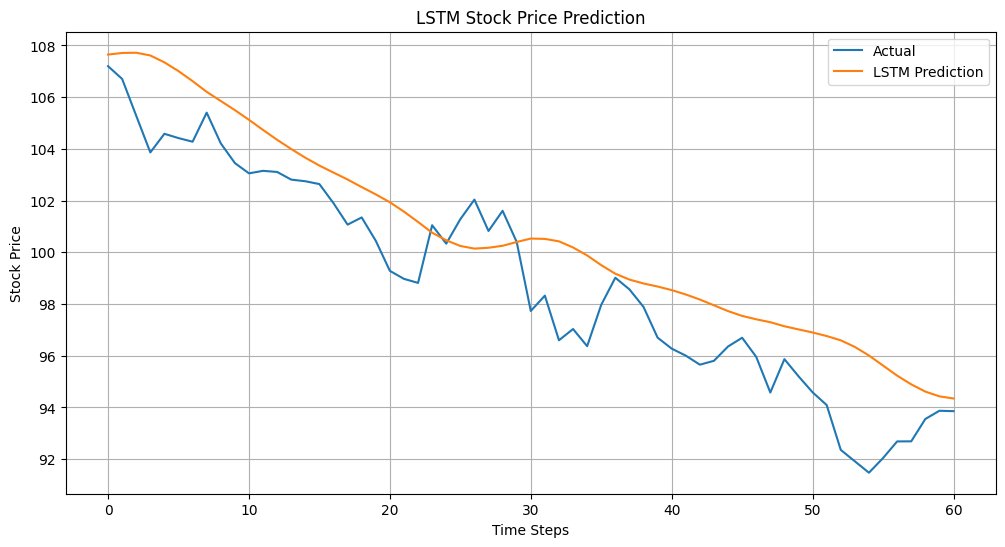

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label="Actual")
plt.plot(y_pred_inv, label="LSTM Prediction")
plt.title("LSTM Stock Price Prediction")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()


# XGBoost Regression

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Flatten 3D LSTM-style input to 2D
X_train_flat = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test_flat = X_test.reshape(X_test.shape[0], X_test.shape[1])

# Train XGBoost model
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train_flat, y_train)

# Predict
y_pred_xgb = xgb.predict(X_test_flat)

# Evaluation
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost MSE:", mse_xgb)
print("XGBoost R² Score:", r2_xgb)


XGBoost MSE: 0.00937041256382481
XGBoost R² Score: 0.49376443106867507


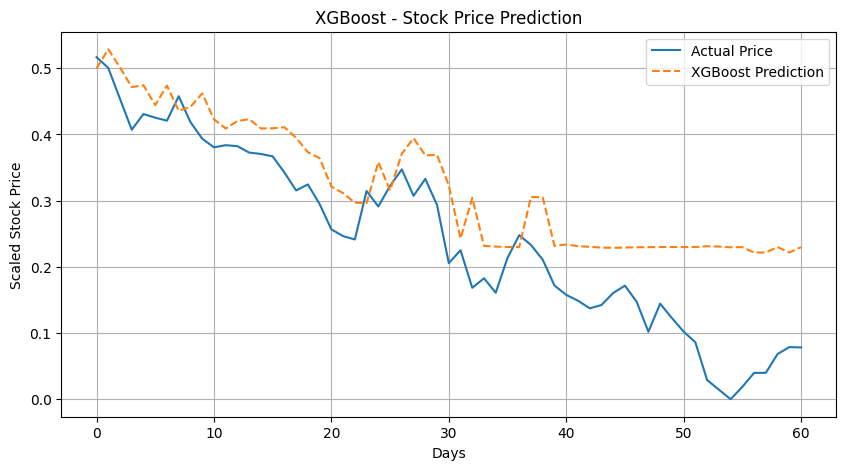

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual Price')
plt.plot(y_pred_xgb, label='XGBoost Prediction', linestyle='--')
plt.title("XGBoost - Stock Price Prediction")
plt.xlabel("Days")
plt.ylabel("Scaled Stock Price")
plt.legend()
plt.grid(True)
plt.show()


Light GBM Regression

In [ ]:
from lightgbm import LGBMRegressor

# Train LightGBM model
lgbm = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
lgbm.fit(X_train_flat, y_train)

# Predict
y_pred_lgbm = lgbm.predict(X_test_flat)

# Evaluation
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print("LightGBM MSE:", mse_lgbm)
print("LightGBM R² Score:", r2_lgbm)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4980
[LightGBM] [Info] Number of data points in the train set: 244, number of used features: 60
[LightGBM] [Info] Start training from score 0.597445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

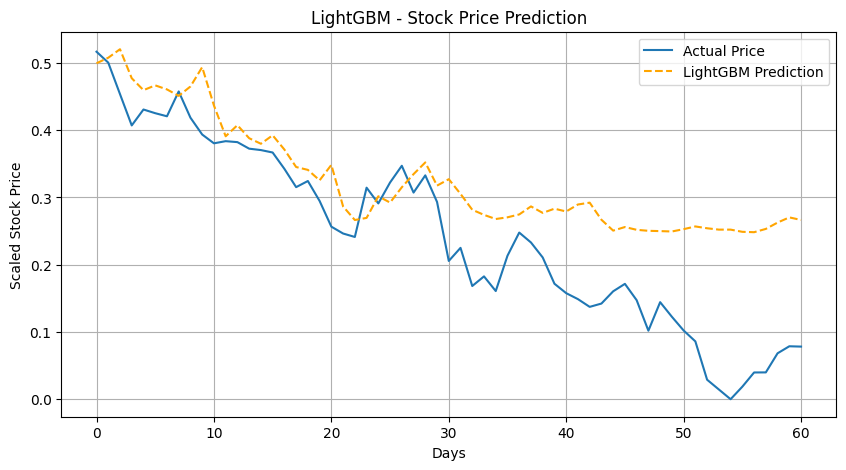

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual Price')
plt.plot(y_pred_lgbm, label='LightGBM Prediction', linestyle='--', color='orange')
plt.title("LightGBM - Stock Price Prediction")
plt.xlabel("Days")
plt.ylabel("Scaled Stock Price")
plt.legend()
plt.grid(True)
plt.show()


Prophet (Time Serise Forcasting)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnzgr2w1d/v8h_a44i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnzgr2w1d/h3b6ab2p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82139', 'data', 'file=/tmp/tmpnzgr2w1d/v8h_a44i.json', 'init=/tmp/tmpnzgr2w1d/h3b6ab2p.json', 'output', 'file=/tmp/tmpnzgr2w1d/prophet_model59kmmues/prophet_model-20250722122409.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet MSE: 53.88789051265952
Prophet R² Score: -11.482194656666861


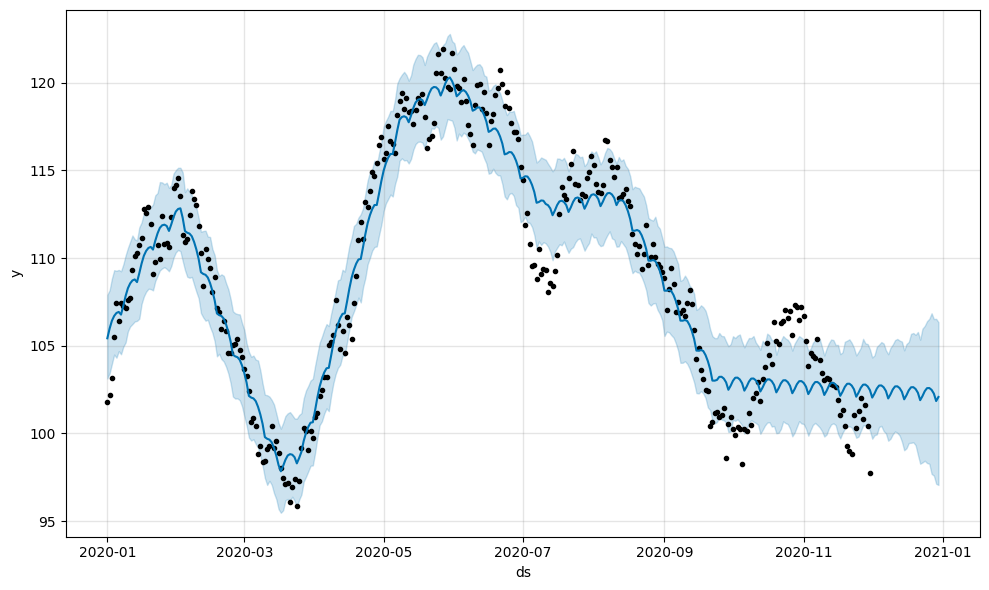

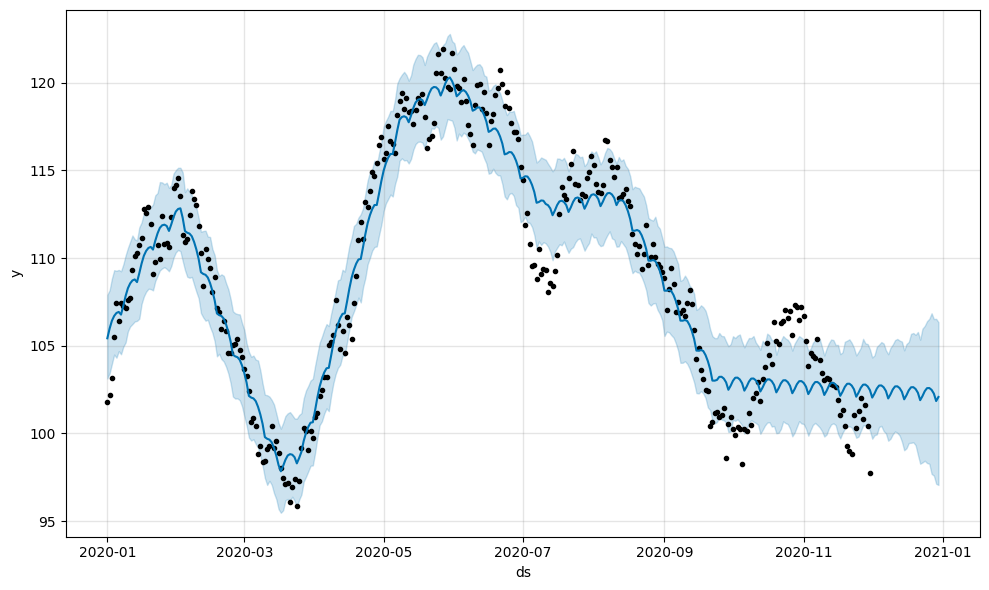

In [ ]:
from prophet import Prophet
import pandas as pd

# Prepare DataFrame for Prophet
df_prophet = df[['Stock_1']].reset_index()
df_prophet.columns = ['ds', 'y']  # Prophet expects 'ds' (date) and 'y' (target)

# Use only a part of the dataset if too large
df_train_prophet = df_prophet.iloc[:-30]  # Train on all but last 30 days
df_test_prophet = df_prophet.iloc[-30:]   # Forecast next 30

# Train the model
prophet = Prophet()
prophet.fit(df_train_prophet)

# Make future dataframe for prediction
future = prophet.make_future_dataframe(periods=30)
forecast = prophet.predict(future)

# Evaluation
y_true_prophet = df_test_prophet['y'].values
y_pred_prophet = forecast.iloc[-30:]['yhat'].values

mse_prophet = mean_squared_error(y_true_prophet, y_pred_prophet)
r2_prophet = r2_score(y_true_prophet, y_pred_prophet)

print("Prophet MSE:", mse_prophet)
print("Prophet R² Score:", r2_prophet)

# Plot Forecast
prophet.plot(forecast)


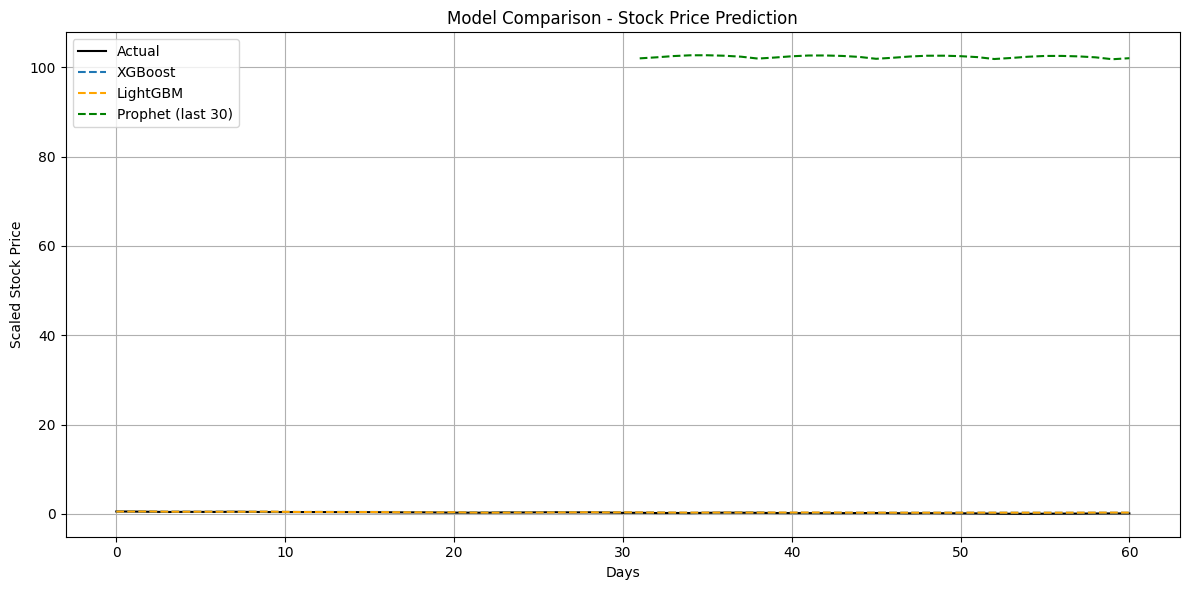

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', color='black')
plt.plot(y_pred_xgb, label='XGBoost', linestyle='--')
plt.plot(y_pred_lgbm, label='LightGBM', linestyle='--', color='orange')
plt.plot(range(len(y_test)-30, len(y_test)), y_pred_prophet, label='Prophet (last 30)', linestyle='--', color='green')

plt.title("Model Comparison - Stock Price Prediction")
plt.xlabel("Days")
plt.ylabel("Scaled Stock Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Result


In [ ]:
results = {
    'Model': ['Linear Regression', 'Random Forest', 'LSTM', 'XGBoost', 'LightGBM', 'Prophet'],
    'MSE': [mse_lr, mse_rf, mse_lstm ,mse_xgb, mse_lgbm, mse_prophet],
    'R2 Score': [r2_lr, r2_rf, r2_lstm, r2_xgb, r2_lgbm, r2_prophet]
}

results_df = pd.DataFrame(results)
print(results_df)

               Model        MSE   R2 Score
0  Linear Regression   0.000931   0.960525
1      Random Forest   0.005563   0.764122
2               LSTM   4.702343   0.725602
3            XGBoost   0.009370   0.493764
4           LightGBM   0.012333   0.333703
5            Prophet  53.887891 -11.482195


Now new six begains

In [ ]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [ ]:
# ML Models
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet, BayesianRidge


In [ ]:
# Deep Learning (GRU)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense


In [ ]:
# Normalize the stock data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Stock_1']])


In [ ]:
# Create sliding window sequences
def create_sequences(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size = 60
X, y = create_sequences(scaled_data, window_size)


In [ ]:
# Prepare GRU input (3D), others use 2D
X_gru = X.reshape(X.shape[0], X.shape[1], 1)
X_flat = X.reshape(X.shape[0], X.shape[1])


In [ ]:
# Train-test split
split = int(len(X) * 0.8)
X_train_flat, X_test_flat = X_flat[:split], X_flat[split:]
y_train, y_test = y[:split], y[split:]
X_train_gru, X_test_gru = X_gru[:split], X_gru[split:]

In [ ]:
# 1. Support Vector Regressor
svr = SVR(kernel='rbf')
svr.fit(X_train_flat, y_train)
y_pred_svr = svr.predict(X_test_flat)


SVR -> MSE: 0.07728780093518554 R2: -3.1754654463052034


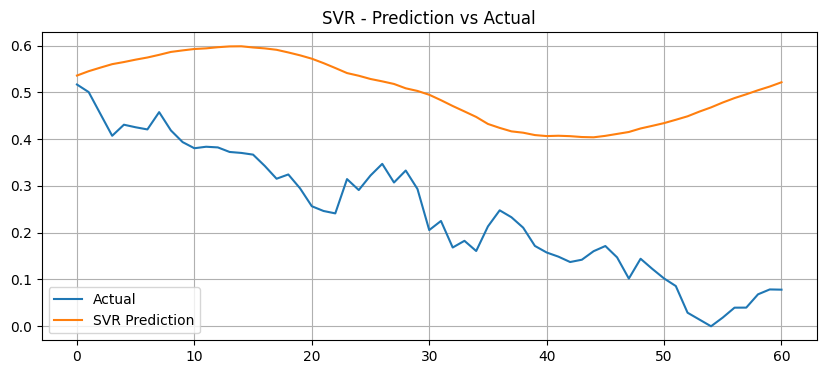

In [ ]:
mse = mean_squared_error(y_test, y_pred_svr)
r2 = r2_score(y_test, y_pred_svr)
# Initialize results as an empty list before appending
results = []
results.append(['SVR', mse, r2])
print("SVR -> MSE:", mse, "R2:", r2)
plt.figure(figsize=(10, 4))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_svr, label='SVR Prediction')
plt.title('SVR - Prediction vs Actual')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 2. KNN Regressor
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_flat, y_train)
y_pred_knn = knn.predict(X_test_flat)


KNN -> MSE: 0.07720490388631639 R2: -3.1709869418198178


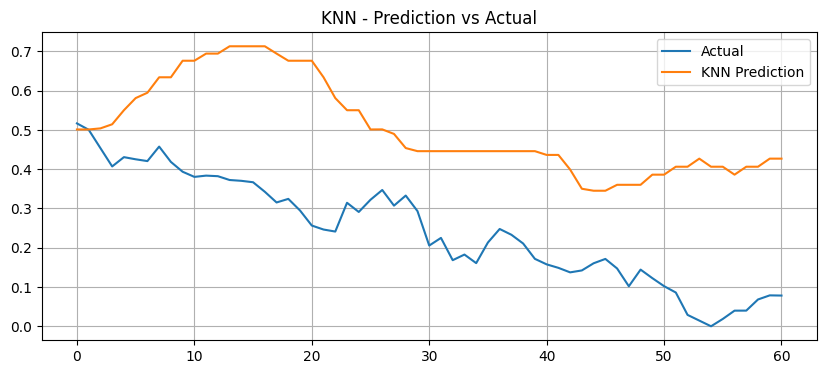

In [ ]:
mse = mean_squared_error(y_test, y_pred_knn)
r2 = r2_score(y_test, y_pred_knn)
results.append(['KNN', mse, r2])
print("KNN -> MSE:", mse, "R2:", r2)
plt.figure(figsize=(10, 4))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_knn, label='KNN Prediction')
plt.title('KNN - Prediction vs Actual')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 3. Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_flat, y_train)
y_pred_dt = dt.predict(X_test_flat)


Decision Tree -> MSE: 0.011624614816838021 R2: 0.3719813876575512


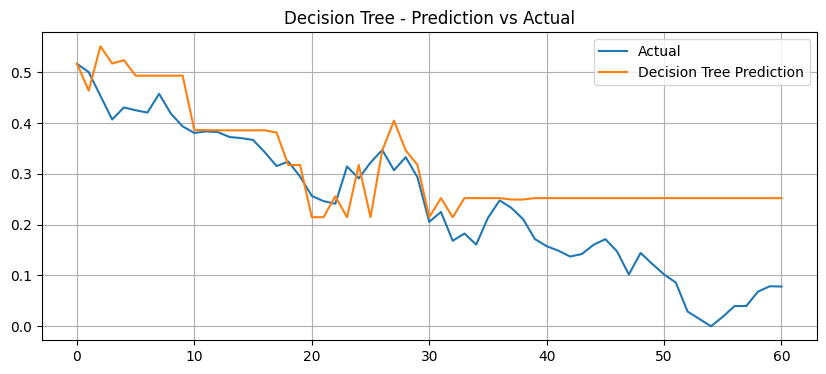

In [ ]:
mse = mean_squared_error(y_test, y_pred_dt)
r2 = r2_score(y_test, y_pred_dt)
results.append(['Decision Tree', mse, r2])
print("Decision Tree -> MSE:", mse, "R2:", r2)
plt.figure(figsize=(10, 4))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_dt, label='Decision Tree Prediction')
plt.title('Decision Tree - Prediction vs Actual')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 4. ElasticNet Regression
en = ElasticNet(alpha=0.1, l1_ratio=0.5)
en.fit(X_train_flat, y_train)
y_pred_en = en.predict(X_test_flat)


ElasticNet -> MSE: 0.12716736746408014 R2: -5.870203865538258


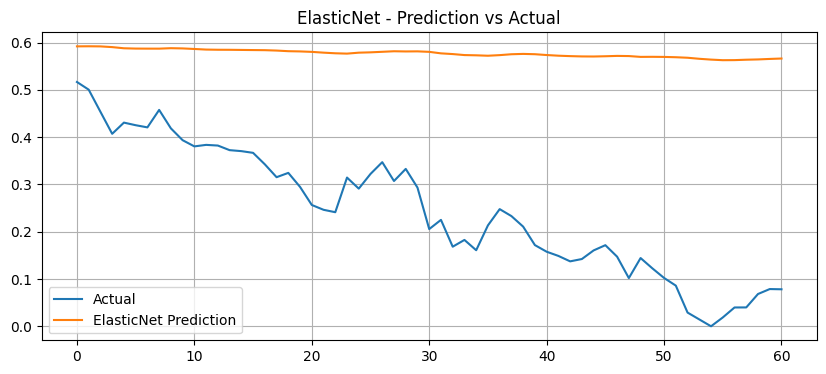

In [ ]:
mse = mean_squared_error(y_test, y_pred_en)
r2 = r2_score(y_test, y_pred_en)
results.append(['ElasticNet', mse, r2])
print("ElasticNet -> MSE:", mse, "R2:", r2)
plt.figure(figsize=(10, 4))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_en, label='ElasticNet Prediction')
plt.title('ElasticNet - Prediction vs Actual')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 5. Bayesian Ridge Regression
br = BayesianRidge()
br.fit(X_train_flat, y_train)
y_pred_br = br.predict(X_test_flat)

Bayesian Ridge -> MSE: 0.0014215785758276151 R2: 0.9231993645730229


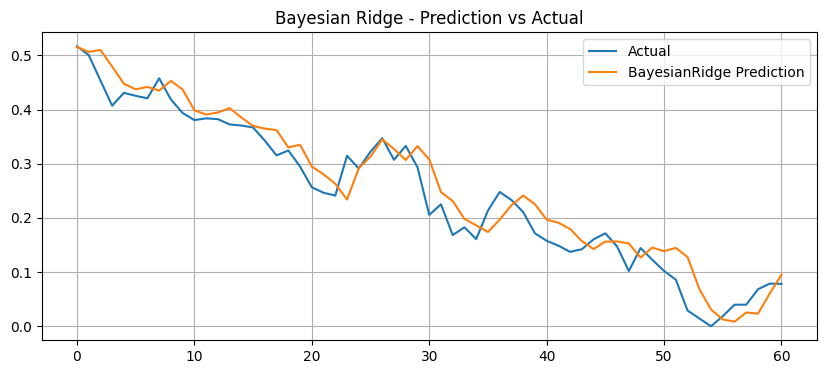

In [ ]:
mse = mean_squared_error(y_test, y_pred_br)
r2 = r2_score(y_test, y_pred_br)
results.append(['Bayesian Ridge', mse, r2])
print("Bayesian Ridge -> MSE:", mse, "R2:", r2)
plt.figure(figsize=(10, 4))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_br, label='BayesianRidge Prediction')
plt.title('Bayesian Ridge - Prediction vs Actual')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 6. GRU (Gated Recurrent Unit)
gru_model = Sequential()
gru_model.add(GRU(units=50, return_sequences=False, input_shape=(X_train_gru.shape[1], 1)))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mean_squared_error')
gru_model.fit(X_train_gru, y_train, epochs=10, batch_size=32, verbose=0)
y_pred_gru = gru_model.predict(X_test_gru).flatten()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


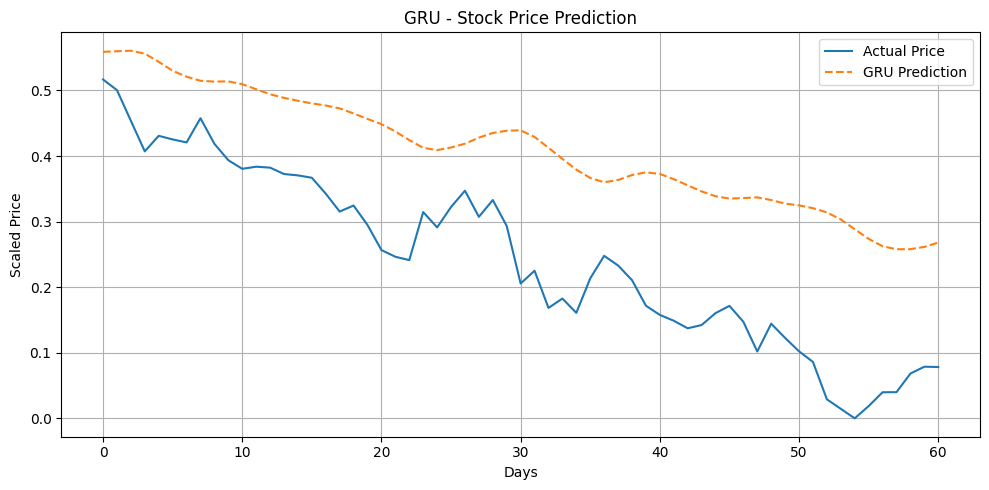

In [ ]:
# Plot Example for GRU
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual Price')
plt.plot(y_pred_gru, label='GRU Prediction', linestyle='--')
plt.title("GRU - Stock Price Prediction")
plt.xlabel("Days")
plt.ylabel("Scaled Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Result


In [ ]:
# Evaluation
models = ['SVR', 'KNN', 'DecisionTree', 'ElasticNet', 'BayesianRidge', 'GRU']
preds = [y_pred_svr, y_pred_knn, y_pred_dt, y_pred_en, y_pred_br, y_pred_gru]

# Append GRU results to the existing results list
mse_gru = mean_squared_error(y_test, y_pred_gru)
r2_gru = r2_score(y_test, y_pred_gru)
results.append(['GRU', mse_gru, r2_gru])


results_df = pd.DataFrame(results, columns=['Model', 'MSE', 'R2 Score'])
print(results_df)

            Model       MSE  R2 Score
0             SVR  0.077288 -3.175465
1             KNN  0.077205 -3.170987
2   Decision Tree  0.011625  0.371981
3      ElasticNet  0.127167 -5.870204
4  Bayesian Ridge  0.001422  0.923199
5             GRU  0.030453 -0.645203
